# Имплементација конволуционе неуронске мреже над CIFAR-10 скупом података

За почетак, потребно је да учитамо све *Python* библиотеке које ћемо користити за потребе овог пројекта.
> Реализација задатка се ослања на коришћење *Keras* API-ја, који је део *TensorFlow* платформе. Основне структуре података на којима се заснива *Keras* су слојеви (енгл. *layers*) и модели (енгл. *models*).

Конволуциона неуронска мрежа коју ћемо имплементирати у овом задатку биће секвенцијална, што значи да ћемо слојеве у мрежи "слагати" један за другим, без гранања у ширину. Зато из библиотеке *keras.models* увозимо постојећу класу *Sequential*. Поред тога, из библиотеке *keras.layers* увозимо класе које представљају типове слојева конволуционе неуронске мреже, које ћемо користити приликом моделирања.
За рад са низовима користићемо библиотеку *numpy*, а за исцртавање и приказ графика за анализу података користићемо библиотеку *matplotlib.pyplot*. 


In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Након тога, потребно је да учитамо одговарајући скуп података. У овом случају се ради о *CIFAR-10* скупу, који већ постоји као саставни део библиотеке *keras.datasets*. Коришћењем функције *load_data* учитавамо скуп података за тренинг и за тестирање.

In [2]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


Како бисмо знали са којим типовима података ћемо радити у наставку, коришћењем функције *type* можемо да пронађемо и прикажемо тип података које смо учитали у претходном кораку.

In [3]:
print(type(x_train))
print(type(y_train))
print(type(x_test))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Сада када знамо да су у питању вишедимензиони низови, позивањем атрибута *shape* добијамо њихове димензије.

In [4]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


Уверили смо се да се скуп података за тренинг састоји од 50000 слика, а скуп података за тест од 10000 слика, као и да су димензије слика 32x32 пиксела, којима су придружене три вредности из скупа RGB (енгл. *Red Green Blue*). Са стране саме структуре података, улазни тренинг и тест скупови (означени су словом *x*) представљају низ матрица димензија 32x32 (у програмском језику *Python* матрице су имплементиране као „низ низова“), чији су чланови низови од по три бројне вредности. Ово можемо проверити, на пример, приказивањем првог члана улазног тренинг скупа.

In [5]:
index = 0
x_train[index]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

С обзиром на то да је у питању ипак слика, можемо је приказати коришћењем функције *imshow*, која је део библиотеке *matplotlib.pyplot*.

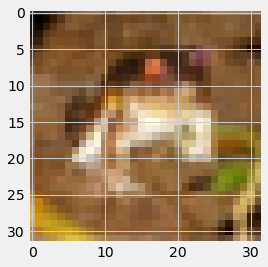

In [6]:
img = plt.imshow(x_train[index])

Вратимо се сада на учитане низове. Излазни тренинг и тест подаци (означени су словом *y*) представљају низ једночланих низова, чији је члан бројна вредност. И ово се може проверити на врло једноставан начин – можемо да прикажемо први члан излазног тренинг скупа. Он одговара индексу класе којој припада први члан улазног тренинг низа, тачније слика коју смо учитали у претходном кораку.

In [7]:
print('The image label is: ', y_train[index])

The image label is:  [6]


Пошто није згодно да памтимо који индекс одговара којој класи, на основу познате класификације и редоследа класа можемо да креирамо низ чији ће чланови бити називи класа, распоређени по познатом редоследу. Овај низ онда можемо индексирати одговарајућим индексом, добијеним из учитаних излазних тренинг и тест низова, како бисмо приказали назив класе којој одређена улазна слика припада.

In [8]:
classification = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('The image class is: ', classification[y_train[index][0]])

The image class is:  frog


> Број излаза из конволуционе неуронсе мреже (то јест број неурона у излазном слоју) одговара броју могућих класа. Дакле, излаз из мреже представља низ вероватноћа да улазна слика одговара свакој од понуђених класа појединачно.

Посматрајући наше учитане излазне тренинг и тест низове можемо да закључимо да се учитани излазни подаци не налазе у одговарајућем формату. За форматирање ових низова на одговарајући начин искористићемо функцију *to_categorical*, која је део библиотеке *keras.utils*. Она имплементира такозвано *one hot* кодирање, чиме се постиже жељени формат излазних тренинг и тест података.


In [9]:
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

Проверићемо да ли је функција *to_categorical* одрадила свој посао.

In [10]:
print(y_train_one_hot)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


Узмимо, на пример, први излазни тренинг податак – индекс класе првог улазног тренинг податка је шест. Применом *one hot* кодирања, индекс шест ће бити представљен као низ од десет бројева, од којих је девет једнако нули, а шести број по реду у датом низу је једнак јединици.

In [11]:
print('The one hot label is:', y_train_one_hot[0])

The one hot label is: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


Следеће што је потребно да урадимо јесте да нормализујемо улазне тренинг и тест податке. Наиме, RGB вредности у оквиру улазних тренинг и тест низова су дефинисане целим бројевима од 0 до 255. Како бисмо ове вредности пресликали у скуп реалних бројева од 0 до 1, потребно је да поделимо све бројевне вредности улазних тренинг и тест низова са 255.

In [12]:
x_train = x_train / 255
x_test = x_test / 255

Као што је већ напоменуто, користићемо секвенцијални модел конволуционе неуронске мреже, па ћемо га иницијализовати креирањем објекта класе *Sequential*.

In [13]:
model = Sequential()

Коришћењем функције *add* додајемо жељене слојеве на наш модел. Први слој је, наравно, слој конволуције. Састојаће се од 32 филтера (први параметар), које представљају кернели димензија 5x5 пиксела (други параметар). Дефинисањем параметра *activation* као што је приказано, поставићемо ReLU активациону функцију. 
>Оно што је специфично за први слој у односу на остале слојеве конволуције које ћемо додавати у нашем моделу јесте то да је потребно дефинисати параметар *input_shape*, како би се извршила адекватна повезивања са улазним слојем, чије су димензије једнаке димензијама улазних слика – 32x32x3.


In [14]:
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(32,32,3)))

Након првог слоја конволуције можемо, на пример, додати слој сажимања по max pooling принципу. Дефинисани одбирци сажимања су оквири величине 2x2 пиксела (параметар *pool_size*). Подразумевана вредност корака је 2 пиксела.

In [15]:
model.add(MaxPooling2D(pool_size=(2, 2)))

Понављајући овај поступак можемо да додајемо још слојева конволуције и сажимања. За сада ћемо додати још један слој конволуције и још један слој сажимања по *max pooling* принципу. Овог пута ћемо, у оквиру слоја конволуције, дефинисати 64 филтера. 

In [16]:
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

У овом кораку ће се на излазу из слоја конволуције добити 64 матрица димензија 10x10, док ће се на излазу из слоја сажимања њихове димензије преполовити. Дакле, добићемо 64 матрице димензија 5x5. За улазне податке овако малих димензија нема више потребе за додатним сажимањима, па можемо прећи на додавање првог потпуно повезаног слоја, који се дефинише као објекат класе *Flatten* и служи за формирање улазног вектора за наредне потпуно повезане слојеве.

In [17]:
model.add(Flatten())

Потпуно повезани слојеви се дефинишу објектима класе *Dense*. Конструктору ове класе се као први параметар прослеђује број неурона у слоју, а дефинисањем параметра activation постављамо активациону функцију. У оквиру нашег модела ћемо поставити три потпуно повезана слоја, са ReLU активационом функцијом и 1000, 500 и 250 неурона, респективно. 



Такође, дата је могућност постављања *dropout* слојева, дефинисањем објеката класе *Dropout*. Конструктору ове класе се прослеђује *float* вредност од 0 до 1, која представља вероватноћу деактивирања било ког неурона у слоју (енгл. *dropout rate*). У оквиру нашег модела ћемо између првог и другог и другог и трећег потпуно повезаног слоја поставити *dropout* слојеве, са предефинисаном вероватноћом од 50% (0,5).

In [18]:
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(250, activation='relu'))

На самом излазу из мреже налази се последњи потпуно повезан слој који, као што смо већ споменули, садржи 10 неурона. Такође, карактеристично за овај слој је то што користи *SoftMax* активациону функцију.

In [19]:
model.add(Dense(10, activation='softmax'))

Последњи корак у креирању модела мреже јесте компајлирање, за шта користимо функцију *compile*. У оквиру ове функције је потребно дефинисати функцију за процену грешке (параметар *loss*), функцију оптимизације (параметар *optimizer*) и функцију метрике за процену перформанси модела (параметар *metrics*). Одабрана је *cross entropy* метода за процену грешке, позивом класе *CategoricalCrossentropy*, која је део библиотеке *keras.losses*. За функцију оптимизације изабрана је имплементација *Adam* алгоритма, у оквиру истоимене класе, која је део библиотеке* keras.optimizers*. За процену перформанси модела изабрана је функционалност имплементирана у оквиру класе *Accuracy*, која је део библиотеке *keras.metrics* и служи да израчунава колико често се предвиђање модела поклапа са стварном класификацијом.

In [20]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

Обучавање модела се покреће позивањем функције *fit*. Као први и други параметар ове функције прослеђујемо тренинг низ улазних података и форматирани тренинг низ излазних података. Поред тога, дефинисани су и параметри *batch_size*, који представља један од хиперпараметара неуронске мреже, као и број епоха (параметар *epoch*). Такође, дефинисан је и удео података који ће се користити за валидацију (параметар *validation_split*).

In [21]:
hist = model.fit(x_train, y_train_one_hot, 
           batch_size=256, epochs=10, validation_split=0.2 )

Epoch 1/10
157/157 [==============================] - 93s 577ms/step - loss: 1.7742 - accuracy: 0.3394 - val_loss: 1.5137 - val_accuracy: 0.4492
Epoch 2/10
157/157 [==============================] - 87s 555ms/step - loss: 1.4111 - accuracy: 0.4838 - val_loss: 1.2746 - val_accuracy: 0.5381
Epoch 3/10
157/157 [==============================] - 86s 550ms/step - loss: 1.2532 - accuracy: 0.5487 - val_loss: 1.2302 - val_accuracy: 0.5561
Epoch 4/10
157/157 [==============================] - 93s 593ms/step - loss: 1.1376 - accuracy: 0.5919 - val_loss: 1.1065 - val_accuracy: 0.6061
Epoch 5/10
157/157 [==============================] - 106s 670ms/step - loss: 1.0441 - accuracy: 0.6298 - val_loss: 1.0227 - val_accuracy: 0.6339
Epoch 6/10
157/157 [==============================] - 93s 589ms/step - loss: 0.9579 - accuracy: 0.6610 - val_loss: 0.9544 - val_accuracy: 0.6709
Epoch 7/10
157/157 [==============================] - 86s 550ms/step - loss: 0.8818 - accuracy: 0.6897 - val_loss: 0.9574 - val_a

Након завршеног обучавања, време је да тестирамо наш модел. Евалуација се врши позивањем функције *evaluate* и прослеђивањем улазног и излазног низа података за тестирање.

In [22]:
model.evaluate(x_test, y_test_one_hot)[1]

313/313 [==============================] - 7s 24ms/step - loss: 0.9753 - accuracy: 0.6678


0.6678000092506409

За анализу процеса обучавања могуће је креирати график процене тачности током самог процеса.

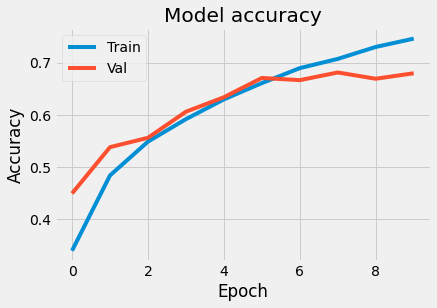

In [23]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

На исти начин је могуће приказати функцију за процену грешке.

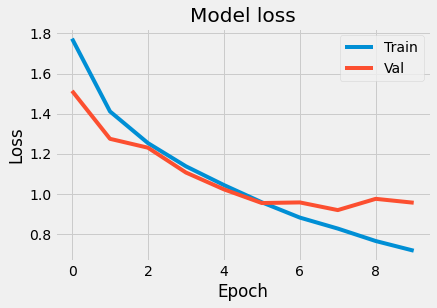

In [24]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

На самом крају, остаје нам да тестирамо модел над произвољном сликом, на којој се налази објекат који припада некој од понуђених класа. 

In [25]:
from google.colab import files
uploaded = files.upload()

Saving dog.jpg to dog.jpg


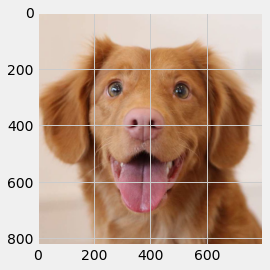

In [26]:
new_image = plt.imread("dog.jpg")
img = plt.imshow(new_image)

Примећујемо да ова слика није одговарајуће резолуције, па је потребно да је смањимо (енгл. *resize*). Ово можемо да урадимо користећи функцију *resize*, која је део библиотеке *skimage.transform*, прослеђујући јој жељену резолуцију. У нашем случају ће то бити 32x32x3.

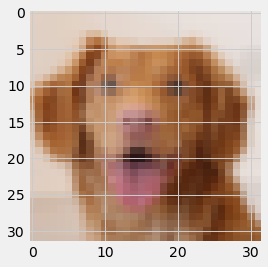

In [27]:
from skimage.transform import resize
resized_image = resize(new_image, (32,32,3))
img = plt.imshow(resized_image)

Коришћењем функције *predict* доводимо нашу слику на улаз креираног модела конволуционе неуронске мреже. Резултат ове функције су вероватноће да објекат на слици припада свакој од понуђених класа појединачно.

In [28]:
predictions = model.predict(np.array( [resized_image] ))
predictions

1/1 [==============================] - 0s 125ms/step


array([[2.3101446e-05, 3.7429967e-05, 1.1658489e-02, 2.5323063e-01,
        9.2152203e-04, 5.8279216e-01, 1.4457870e-01, 6.3210223e-03,
        4.6581254e-06, 4.3234840e-04]], dtype=float32)

Сортираћемо ове вредности од највеће до најмање како бисмо приказали првих пет класа са највећом вероватноћом.

In [30]:
list_index = [0,1,2,3,4,5,6,7,8,9]
x = predictions
for i in range(10):
  for j in range(10):
    if x[0][list_index[i]] > x[0][list_index[j]]:
      temp = list_index[i]
      list_index[i] = list_index[j]
      list_index[j] = temp

i=0
for i in range(5):
  print(classification[list_index[i]], ':', round(predictions[0][list_index[i]] * 100, 2), '%')

dog : 58.28 %
cat : 25.32 %
frog : 14.46 %
bird : 1.17 %
horse : 0.63 %
